# Extracting Important Frames from the Video

In [1]:
from frame_detector import extract_frames, find_move, compute_edge_mean
from board_warper import warp_chessboard, get_closest_tile
from pgn_converter import moves_to_pgn, is_valid_move
import cv2
import os
import shutil
from ultralytics import YOLO
import chess
import chess.svg
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import csv
video_paths = {
    n: f"cu-chess-detection-2025\\Chess Detection Competition\\test_videos\\{n}_move_student.mp4"
    for n in [2, 4, 6, 8]
}
video_paths["2_rotate"] = "cu-chess-detection-2025\\Chess Detection Competition\\test_videos\\2_move_rotate_student.mp4"
video_paths["bonus"] = "cu-chess-detection-2025\\Chess Detection Competition\\bonus_video\\Bonus Long Video Label.mp4"
ref = cv2.imread("ref.jpg")
centers = {(0, 0): (148, 148), (0, 1): (148, 251), (0, 2): (148, 354), (0, 3): (148, 457), (0, 4): (148, 560), (0, 5): (148, 663), (0, 6): (148, 766), (0, 7): (148, 869), (1, 0): (251, 148), (1, 1): (251, 251), (1, 2): (251, 354), (1, 3): (251, 457), (1, 4): (251, 560), (1, 5): (251, 663), (1, 6): (251, 766), (1, 7): (251, 869), (2, 0): (354, 148), (2, 1): (354, 251), (2, 2): (354, 354), (2, 3): (354, 457), (2, 4): (354, 560), (2, 5): (354, 663), (2, 6): (354, 766), (2, 7): (354, 869), (3, 0): (457, 148), (3, 1): (457, 251), (3, 2): (457, 354), (3, 3): (457, 457), (3, 4): (457, 560), (3, 5): (457, 663), (3, 6): (457, 766), (3, 7): (457, 869), (4, 0): (560, 148), (4, 1): (560, 251), (4, 2): (560, 354), (4, 3): (560, 457), (4, 4): (560, 560), (4, 5): (560, 663), (4, 6): (560, 766), (4, 7): (560, 869), (5, 0): (663, 148), (5, 1): (663, 251), (5, 2): (663, 354), (5, 3): (663, 457), (5, 4): (663, 560), (5, 5): (663, 663), (5, 6): (663, 766), (5, 7): (663, 869), (6, 0): (766, 148), (6, 1): (766, 251), (6, 2): (766, 354), (6, 3): (766, 457), (6, 4): (766, 560), (6, 5): (766, 663), (6, 6): (766, 766), (6, 7): (766, 869), (7, 0): (869, 148), (7, 1): (869, 251), (7, 2): (869, 354), (7, 3): (869, 457), (7, 4): (869, 560), (7, 5): (869, 663), (7, 6): (869, 766), (7, 7): (869, 869)}

In [2]:
for k, v in video_paths.items():
    print(f"Extracting: k = {k}...")
    first_frame, extracted_frames = extract_frames(v, ref=ref, centers=centers)

    output_dir = f"storage/extracted_Frames_{k}"
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    for i, frame in enumerate(extracted_frames):
        filename = f"frame_{i:04d}.png"
        cv2.imwrite(os.path.join(output_dir, filename), frame)
print("Frame Extraction Finished!")


Extracting: k = bonus...
Frame Extraction Finished!


# Defining the Board Class

In [2]:
class Board:
    def __init__(self, model, first_frame, tile_centers, ref):
        self.model = model
        self.tile_centers = tile_centers
        self.current_frame = first_frame
        self.ref = ref
        pred = model(first_frame, verbose=False)[0]

        self.piece_positions = {}
        
        for box in pred.boxes:
            # Bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            # Center of the bounding box
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2

            # Class ID → label
            cls_id = int(box.cls[0])
            label = pred.names[cls_id]

            # Find best tile based on center
            tile = get_closest_tile(cx, cy, tile_centers)

            if tile is not None:
                self.piece_positions[tile] = label
    def _to_square(self, row, col):
        """
        Your board:
        (0,0) top-left = h1
        (7,7) bottom-right = a8

        Mapping:
            file = 7 - col
            rank = row
        """
        file = 7 - col
        rank = row
        return chess.square(file, rank)

    def print_svg(self, size=350):
        """
        Build a python-chess board from self.piece_positions and return SVG.
        Optionally save SVG to file.
        """
        # Empty board (None means start from blank)
        board = chess.Board(None)
        # Mapping YOLO labels → python-chess piece types
        label_to_piece = {
            "w_pawn": chess.PAWN,
            "w_knight": chess.KNIGHT,
            "w_bishop": chess.BISHOP,
            "w_rook": chess.ROOK,
            "w_queen": chess.QUEEN,
            "w_king": chess.KING,

            "b_pawn": chess.PAWN,
            "b_knight": chess.KNIGHT,
            "b_bishop": chess.BISHOP,
            "b_rook": chess.ROOK,
            "b_queen": chess.QUEEN,
            "b_king": chess.KING,
        }

        # Add each piece to the board
        for (row, col), label in self.piece_positions.items():
            piece_type = label_to_piece[label]
            color = label.startswith("w")
            sq = self._to_square(row, col)
            board.set_piece_at(sq, chess.Piece(piece_type, color))

        # Generate SVG
        svg = chess.svg.board(board=board, size=size)

        return svg
    def move_board(self, frame_after):
        """
        Attempt to detect move using diff-based method first.
        If it fails or gives inconsistent results, fallback to YOLO re-detection.
        """
        killed = None

        # ---------------------------------------------
        # 1. Try your existing detection logic first
        # ---------------------------------------------
        try:
            detected_move, _ = find_move(
                self.current_frame, frame_after,
                self.tile_centers,
                warped=True,
                ref=self.ref,
                MIN_AREA=200
            )
            #print(detected_move)
            # detected_move must be two tiles
            if detected_move is None or len(detected_move) != 2:
                raise ValueError("find_move returned invalid result")

            centers = self.tile_centers
            center0 = centers[detected_move[0]]
            center1 = centers[detected_move[1]]

            mean_edges = np.array([
                compute_edge_mean(center0, frame_after)[0],
                compute_edge_mean(center1, frame_after)[0]
            ])
            idx = np.argmin(mean_edges)

            before_move = detected_move[idx]
            after_move = detected_move[1 - idx]

            # basic consistency check:
            if before_move not in self.piece_positions:
                raise ValueError("find_move gave a non-piece tile")
            m_piece = self.piece_positions[before_move]
            c, piece_type = m_piece.split("_")
            color = c == "b"

            # Perform move
            if after_move in self.piece_positions:
                if self.piece_positions[before_move].split("_")[0] == self.piece_positions[after_move].split("_")[0]:
                    raise ValueError(f"Cannot capture chess piece on the same team")
                if is_valid_move(piece_type, before_move, after_move, color, capture = True) == False:
                    raise ValueError("Invalid move")
                killed = self.piece_positions.pop(after_move)
            else:
                if is_valid_move(piece_type, before_move, after_move, color) == False:
                    raise ValueError("Invalid move")
        
            moved_piece = self.piece_positions.pop(before_move)
            self.piece_positions[after_move] = moved_piece

            # Update frame
            self.current_frame = frame_after

            return moved_piece, before_move, after_move, killed

        except Exception as e:
            print("[WARN] find_move failed, falling back to YOLO detection:", e)

        # ---------------------------------------------------------
        # 2. FALLBACK: Re-detect all pieces from the model
        # ---------------------------------------------------------
        pred = self.model(frame_after, verbose=False)[0]
        new_positions = {}

        for box in pred.boxes:
            # Bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            # Center of the bounding box
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2

            # Class ID → label
            cls_id = int(box.cls[0])
            label = pred.names[cls_id]

            # Find best tile based on center
            tile = get_closest_tile(cx, cy, self.tile_centers)

            if tile is not None:
                new_positions[tile] = label

        # ---------------------------------------------------------
        # 3. Compare old vs new to detect move
        # ---------------------------------------------------------
        old = self.piece_positions
        new = new_positions

        disappeared = [sq for sq in old if sq not in new]
        appeared = [sq for sq in new if sq not in old]
        changed = [sq for sq in new if sq in old and new[sq] != old[sq]]

        moved_piece = None
        before_move = None
        after_move = None
        killed = None

        # --- Case 1: normal move (no capture) ---
        if len(disappeared) >= 1 and len(appeared) == 1:
            
            #before_move = disappeared[0]
            after_move = appeared[0]
            moved_piece = new[after_move]
            # Find which disappeared square had this piece before the move
            #print(old[(5,3)])
            candidates = [sq for sq in disappeared if old[sq] == moved_piece]

            if len(candidates) != 1:
                raise RuntimeError(
                    f"Ambiguous normal move: disappeared={disappeared}, moved_piece={moved_piece}"
                )

            before_move = candidates[0]

            # Update Board
            self.piece_positions.pop(before_move)
            self.piece_positions[after_move] = moved_piece
        # --- Case 2: capture ---
        elif len(disappeared) >= 1 and len(changed) == 1:
            after_move = changed[0]
            moved_piece = new[after_move]
            killed = old[after_move]  # old piece at destination
            
            # Find which disappeared square had this piece before the move
            candidates = [sq for sq in disappeared if old[sq] == moved_piece]

            if len(candidates) != 1:
                raise RuntimeError(
                    f"Ambiguous normal move: disappeared={disappeared}, moved_piece={moved_piece}"
                )

            before_move = candidates[0]

            # Update Board
            self.piece_positions.pop(before_move)
            self.piece_positions[after_move] = moved_piece
        # --- Anything else = ambiguous ---
        else:
            self.current_frame = frame_after
            #self.piece_positions = new_positions
            return None, None, None, None
            #raise RuntimeError(f"Fallback detection ambiguous: disappeared={disappeared}, appeared={appeared}, changed={changed}")
            
        # ---------------------------------------------------------
        # 4. Apply final board update
        # ---------------------------------------------------------
        #self.piece_positions = new_positions
        self.current_frame = frame_after

        return moved_piece, before_move, after_move, killed
        

# Prediction

## Single video prediction

In [3]:
model = YOLO("model/best.pt")  
def predict_video(extracted_frames, show_output = True):
    first_frame = extracted_frames[0]

    board = Board(model, first_frame, centers, ref)
    if show_output == True:
        svg = board.print_svg(size=350)
        display(SVG(svg))
    
    # Running moves
    moves = []
    for i, move in enumerate(extracted_frames[1:], start=1):
        moved_piece, before_move, after_move, killed = board.move_board(move)
        if moved_piece != None:
            moves.append((moved_piece, before_move, after_move, killed)) #killed = b_pawn
        else:
            print(f"(Move {i}) ERROR: Skipping...")
            continue
        if killed == None:
            if show_output == True:
                print(f"(Move {i}) {moved_piece}: {before_move} -> {after_move}")
        else:
            if show_output == True:
                print(f"(Move {i}) {moved_piece}: {before_move} -> {after_move} (killed: {killed})")
    
    pgn = moves_to_pgn(moves)
    if show_output == True:
        print(pgn)
    return pgn      


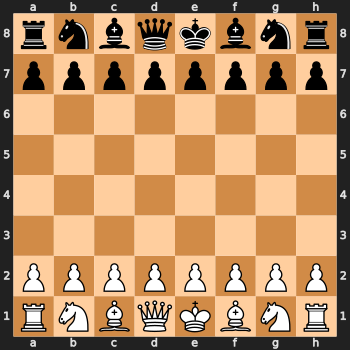

(Move 1) w_pawn: (1, 2) -> (3, 2)
(Move 2) b_pawn: (6, 4) -> (4, 4)
(Move 3) w_knight: (0, 1) -> (2, 2)
(Move 4) b_bishop: (7, 5) -> (4, 2)
[WARN] find_move failed, falling back to YOLO detection: find_move gave a non-piece tile
(Move 5) w_knight: (0, 6) -> (2, 5)
(Move 6) b_knight: (7, 6) -> (5, 5)
(Move 7) w_knight: (2, 5) -> (4, 4) (killed: b_pawn)
(Move 8) b_pawn: (6, 3) -> (5, 3)
(Move 9) w_knight: (4, 4) -> (2, 3)
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 10) ERROR: Skipping...
(Move 11) b_queen: (7, 4) -> (3, 0)
(Move 12) w_knight: (2, 2) -> (3, 0) (killed: b_queen)
(Move 13) b_knight: (7, 1) -> (5, 0)
(Move 14) w_knight: (3, 0) -> (4, 2) (killed: b_bishop)
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 15) ERROR: Skipping...
(Move 16) b_knight: (5, 0) -> (4, 2) (killed: w_knight)
(Move 17) w_knight: (2, 3) -> (4, 2) (killed: b_knight)
(Move 18) b_pawn: (5

In [6]:
folder = "storage\\extracted_Frames_bonus"
extracted_frames = []
for filename in os.listdir(folder):
    filepath = os.path.join(folder, filename)
    img = cv2.imread(filepath)
    extracted_frames.append(img)
pgn = predict_video(extracted_frames)

## All video prediction

In [4]:
video_name = {2:"2_move_student.mp4",
              4:"4_Move_studet.mp4",
              6:"6_Move_student.mp4", 
              8:"8_Move_student.mp4", 
              "2_rotate":"2_Move_rotate_student.mp4", 
              "bonus": "(Bonus)Long_video_student.mp4"}
output_rows = []  # To store (row_id, pgn)
for k in video_paths.keys():
    folder_path = f"storage\\extracted_Frames_{k}"
    # print(folder_path)
    extracted_frames = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        img = cv2.imread(filepath)
        extracted_frames.append(img)
    pgn = predict_video(extracted_frames, show_output=False)
    output_rows.append([video_name[k], pgn])

# Write CSV
csv_path = "video_results.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["row_id", "output"])   # header
    writer.writerows(output_rows)

print("CSV created:", csv_path)

[WARN] find_move failed, falling back to YOLO detection: Invalid move
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
[WARN] find_move failed, falling back to YOLO detection: find_move gave a non-piece tile
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 10) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 15) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 24) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 27) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 32) ERROR: S

# Debugging

In [43]:
import matplotlib.pyplot as plt
def compute_edge_mean(center, frame, tile_size=103, thresh=25):
    """
    center: (cx, cy) tile center coordinates
    frame: image (BGR)
    tile_size: width/height of each tile
    thresh: pixel threshold to decide if something exists
    """
    h, w = frame.shape[:2]
    cx, cy = center

    half = tile_size // 2

    # Compute tile bounds (clamped to image edges)
    x1 = max(cy - half, 0)  # frame[y][x] so watch order
    y1 = max(cx - half, 0)
    x2 = min(cy + half, w)
    y2 = min(cx + half, h)

    # Extract ROI
    tile_roi = frame[y1:y2, x1:x2]
    tile_hsv = cv2.cvtColor(tile_roi, cv2.COLOR_BGR2HSV)
    hue_mean = np.mean(tile_hsv[:, :, 0])
    sat_mean = np.mean(tile_hsv[:, :, 1])
    #For Debugging
    # plt.imshow(cv2.cvtColor(tile_roi, cv2.COLOR_BGR2RGB))
    # plt.show()

    # Convert to grayscale
    gray = cv2.cvtColor(tile_roi, cv2.COLOR_BGR2GRAY)

    # Detect piece by intensity variation
    # Compute standard deviation: high means structure → piece exists
    edges = cv2.Canny(gray, 50, 150)
    
    plt.imshow(edges, cmap="gray")
    plt.show()
    # print(edges.mean())
    return edges.mean(), hue_mean, sat_mean

def validate_move(uncropped_before, uncropped_after, centers, tile):
    c = centers[tile]
    before_edge_mean, before_hue, before_sat = compute_edge_mean(c, uncropped_before)
    after_edge_mean, after_hue, after_sat = compute_edge_mean(c, uncropped_after)
    
    edge_diff = abs(before_edge_mean - after_edge_mean)
    hue_diff = abs(before_hue - after_hue)
    sat_diff = abs(before_sat - after_sat)
    
    # Handle hue wraparound (hue is circular: 0° = 180°)
    hue_diff = min(hue_diff, 180 - hue_diff)
    
    # Adjust thresholds as needed
    print(hue_diff)
    print("edge_diff", edge_diff)
    if edge_diff < 3 and hue_diff < 15:
        return False
    else:
        return True

In [14]:
from frame_detector import hand_mask_skin
h, w = before.shape[:2]

before_cropped = before[90:h-90, 90:w-90].copy()

hand_pixels = cv2.countNonZero(hand_mask_skin(before_cropped))

In [15]:
hand_pixels

9475

In [ ]:
def read_frame_at_time(video_path, t_seconds):
    """
    Read a video frame at time t (in seconds).
    Returns: frame (BGR) or None if time is out of range.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: cannot open video")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Convert time (sec) → frame index
    frame_index = int(t_seconds * fps)

    if frame_index >= total_frames:
        print("Error: time exceeds video length")
        cap.release()
        return None

    # Seek to that frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Error: failed to read frame at", t_seconds, "seconds")
        return None

    return frame
video_path = "cu-chess-detection-2025\\Chess Detection Competition\\bonus_video\\Bonus Long Video Label.mp4"
frame_1 = warp_chessboard(read_frame_at_time(video_path, 33), ref=ref)
frame_2 = warp_chessboard(read_frame_at_time(video_path, 39), ref=ref)
frame_3 = warp_chessboard(read_frame_at_time(video_path, 46), ref=ref)
frame_4 = warp_chessboard(read_frame_at_time(video_path, 70), ref=ref)
frame_5 = warp_chessboard(read_frame_at_time(video_path, 85), ref=ref)

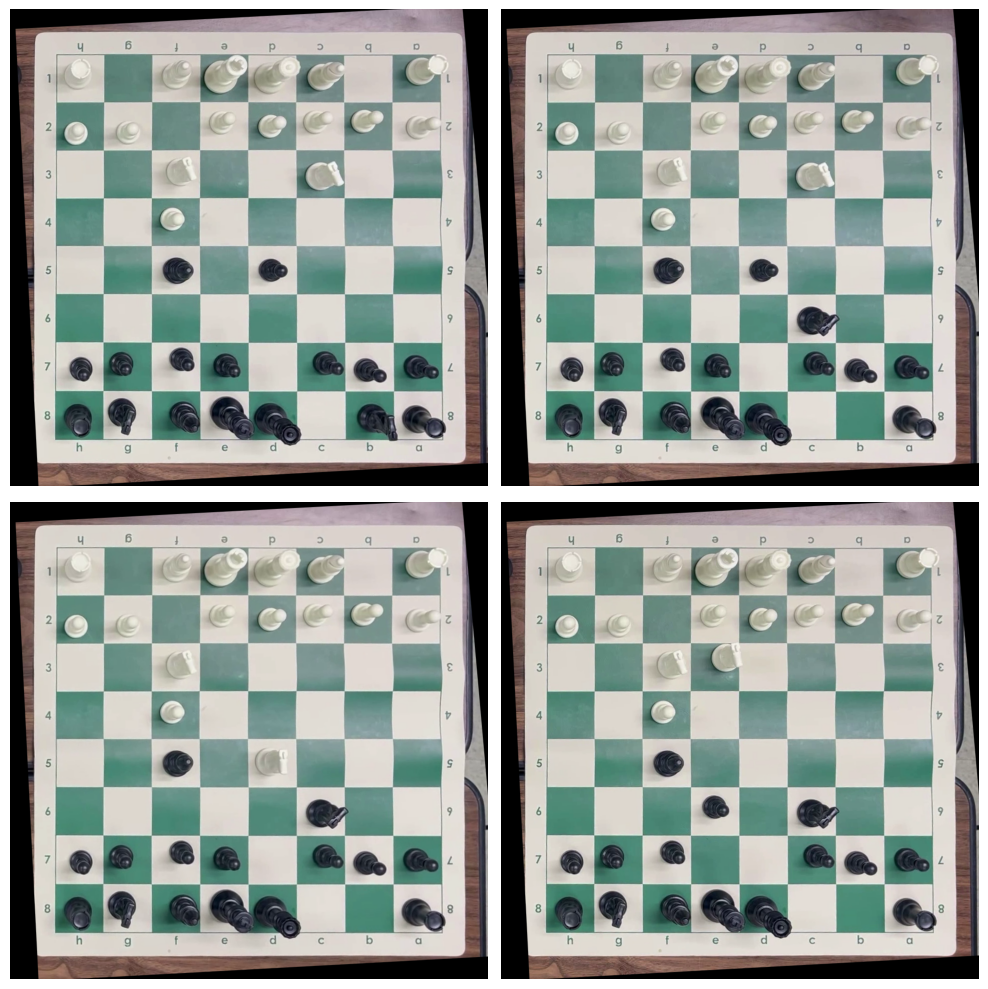

In [41]:
def plot_4_images(img1, img2, img3, img4, titles=None):
    imgs = [img1, img2, img3, img4]
    if titles is None:
        titles = ["", "", "", ""]

    plt.figure(figsize=(10,10))

    for i, img in enumerate(imgs):
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_4_images(frame_1,frame_2,frame_3,frame_4)

In [50]:
from frame_detector import validate_move
import matplotlib.pyplot as plt
#from frame_detector import validate_move
def find_move(before, after, centers, warped=True, ref=None, MIN_AREA=920, MAX_AREA=12000, crop = 90):
    if warped:
        warped_before = before.copy()
        warped_after = after.copy()
    else:
        warped_before = warp_chessboard(before, ref=ref)
        warped_after = warp_chessboard(after, ref=ref)
    
    h, w = warped_before.shape[:2]
    before_uncropped = warped_before.copy()
    after_uncropped = warped_after.copy()
    warped_before = warped_before[crop:h-crop, crop:w-crop].copy()
    warped_after = warped_after[crop:h-crop, crop:w-crop].copy()

    diff = cv2.absdiff(warped_before, warped_after)

    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    #_, thresh = cv2.threshold(diff_gray, 15, 255, cv2.THRESH_BINARY)
    thresh = cv2.adaptiveThreshold(
        diff_gray, 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C,  # or cv2.ADAPTIVE_THRESH_MEAN_C
        cv2.THRESH_BINARY, 
        blockSize=401,  # Must be odd; adjust based on tile size
        C=-17  # Negative value to keep threshold around 15
    )
    # ----- Added erosion -----
    kernel = np.ones((7,7), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    # ------- Debug -----------
    plt.imshow(diff_gray, cmap='gray')
    plt.show()
    plt.imshow(thresh, cmap='gray')
    plt.show()
    if cv2.countNonZero(thresh) > 30000:
        return [], []
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    cnts = cnts[:2]    # only the 2 largest
    # -------------------------------------------------------

    detected_tiles = []
    areas = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < MIN_AREA or area > MAX_AREA:
            continue
        areas.append(area)

        x, y, w, h = cv2.boundingRect(c)
        cx, cy = x + w//2 + crop, y + h//2 + crop

        tile = get_closest_tile(cx, cy, centers)
        if validate_move(before_uncropped, after_uncropped, centers, tile) == True:
            detected_tiles.append(tile)
    if len(detected_tiles) == 2:
        if detected_tiles[0] == detected_tiles[1]:
            detected_tiles = []
    return detected_tiles, areas



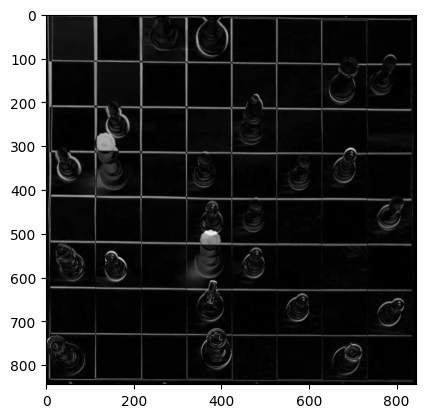

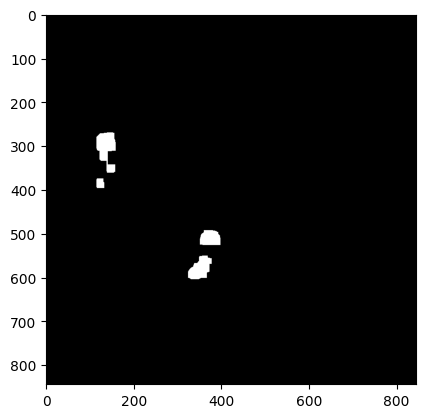

([(3, 1), (5, 3)], [2404.0, 1864.5])

In [51]:
before = cv2.imread("extracted_Frames/frame_0000.png")
after = cv2.imread("extracted_Frames/frame_0001.png")
find_move(before, after, centers)

In [17]:
from frame_detector import hand_mask_skin
frame = cv2.imread("extracted_Frames/frame_0010.png")
h, w = frame.shape[:2]

frame_cropped = frame[90:h-90, 90:w-90].copy()
mask = hand_mask_skin(frame_cropped)
cv2.countNonZero(mask)

3119

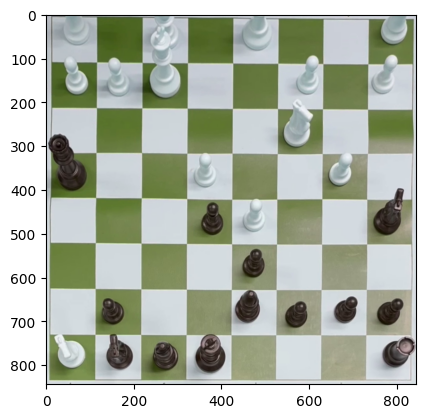

In [4]:
import matplotlib.pyplot as plt
plt.imshow(frame_cropped)

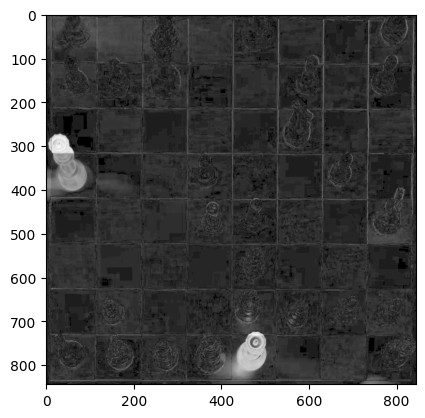

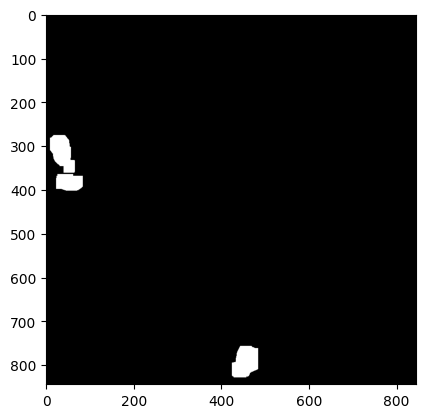

3380.5
3240.5


([(7, 4), (3, 0)], [3380.5, 3240.5])

In [91]:
from frame_detector import validate_move
def adjust_gamma(image, gamma=1.0):
    # Build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)
def find_move(before, after, centers, warped=True, ref=None, MIN_AREA=700, MAX_AREA=12000, crop = 90):
    if warped:
        warped_before = before.copy()
        warped_after = after.copy()
    else:
        warped_before = warp_chessboard(before, ref=ref)
        warped_after = warp_chessboard(after, ref=ref)
    
    h, w = warped_before.shape[:2]
    before_uncropped = warped_before.copy()
    after_uncropped = warped_after.copy()
    warped_before = warped_before[crop:h-crop, crop:w-crop].copy()
    warped_after = warped_after[crop:h-crop, crop:w-crop].copy()

    diff = cv2.absdiff(warped_before, warped_after)

    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    diff_gray = adjust_gamma(diff_gray, gamma=2.5)
    
    thresh = cv2.adaptiveThreshold(
            diff_gray, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            blockSize=201,  
            C=-10
        )
    #_, thresh = cv2.threshold(diff_gray, 15, 255, cv2.THRESH_BINARY)

    # ----- Added erosion -----
    kernel = np.ones((7,7), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)
    
    #------- Debug -----------
    plt.imshow(diff_gray, cmap='gray')
    plt.show()
    plt.imshow(thresh, cmap='gray')
    plt.show()

    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    cnts = cnts[:2]    # only the 2 largest
    # -------------------------------------------------------

    detected_tiles = []
    areas = []
    for c in cnts:
        
        area = cv2.contourArea(c)
        print(area)
        if area < MIN_AREA or area > MAX_AREA:
            continue
        areas.append(area)

        x, y, w, h = cv2.boundingRect(c)
        cx, cy = x + w//2 + crop, y + h//2 + crop

        tile = get_closest_tile(cx, cy, centers)
        if validate_move(before_uncropped, after_uncropped, centers, tile) == True:
            detected_tiles.append(tile)

    return detected_tiles, areas
before = cv2.imread("extracted_Frames/frame_0000.png")
after = cv2.imread("extracted_Frames/frame_0001.png")
find_move(before, after, centers)


In [5]:
find_move(extracted_frames[0], extracted_frames[1], centers, warped=True)

([(3, 2), (5, 2)], [3147.0, 3091.5])

In [7]:
from frame_detector import compute_edge_mean
def find_move(before, after, centers, warped=True, ref=None, MIN_AREA=1000, crop = 90):
    if warped:
        warped_before = before.copy()
        warped_after = after.copy()
    else:
        warped_before = warp_chessboard(before, ref=ref)
        warped_after = warp_chessboard(after, ref=ref)
    
    h, w = warped_before.shape[:2]
    before_uncropped = warped_before.copy()
    after_uncropped = warped_after.copy()
    warped_before = warped_before[crop:h-crop, crop:w-crop].copy()
    warped_after = warped_after[crop:h-crop, crop:w-crop].copy()
    diff = cv2.absdiff(warped_before, warped_after)

    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(diff_gray, 15, 255, cv2.THRESH_BINARY)

    # ----- Added erosion -----
    kernel = np.ones((7,7), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # ------- Debug -----------
    # plt.imshow(diff_gray, cmap='gray')
    # plt.show()
    # plt.imshow(thresh, cmap='gray')
    # plt.show()

    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    cnts = cnts[:2]    # only the 2 largest
    # -------------------------------------------------------

    detected_tiles = []
    areas = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < MIN_AREA:
            continue
        areas.append(area)

        x, y, w, h = cv2.boundingRect(c)
        cx, cy = x + w//2 + crop, y + h//2 + crop

        tile = get_closest_tile(cx, cy, centers)
        #if validate_move(before_uncropped, after_uncropped, centers, tile) == True:
        c = centers[tile]
        print(compute_edge_mean(c, before_uncropped))
        print(compute_edge_mean(c, after_uncropped))

        detected_tiles.append(tile)

    return detected_tiles, areas

In [8]:
find_move(extracted_frames[3], extracted_frames[4], centers)

(np.float64(5.416666666666667), np.float64(86.6864347046008))
(np.float64(3.6519607843137254), np.float64(73.8797898244265))


([(0, 1)], [2534.0])

In [16]:
import matplotlib.pyplot as plt
def compute_edge_mean(center, frame, tile_size=103, edge_low=50, edge_high=150):
    """
    Compute edge density in a tile to detect piece presence.
    Higher edge density indicates a piece is present.
    
    Args:
        center: (cx, cy) tile center coordinates
        frame: Image (BGR)
        tile_size: Width/height of each tile
        edge_low: Lower threshold for Canny edge detection
        edge_high: Upper threshold for Canny edge detection
    
    Returns:
        Mean edge intensity (float)
    """
    h, w = frame.shape[:2]
    cx, cy = center
    half = tile_size // 2
    
    # Compute tile bounds
    x1 = max(cy - half, 0)  # frame[y][x] so watch order
    y1 = max(cx - half, 0)
    x2 = min(cy + half, w)
    y2 = min(cx + half, h)
    
    # Extract tile ROI
    tile_roi = frame[y1:y2, x1:x2]
    
    if tile_roi.size == 0:
        return 0.0
    # plt.imshow(tile_roi)
    # plt.show()
    # Convert to grayscale
    gray = cv2.cvtColor(tile_roi, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Detect edges
    edges = cv2.Canny(gray, edge_low, edge_high)
    
    return edges.mean()
compute_edge_mean(centers[(3,2)],extracted_frames[1])

np.float64(16.102941176470587)

In [9]:
find_move(extracted_frames[0],extracted_frames[1],centers,warped=True)

([(5, 2), (3, 2)], [2071.5, 1397.0])

In [13]:
from frame_detector import hand_mask_skin, draw_hand_mask
import matplotlib.pyplot as plt

def compute_pixel_differences(before, after, warped=True, ref = None, threshold=30):
    if warped == True:
        warped_before = before.copy()
        warped_after = after.copy()
    else:
        warped_before = warp_chessboard(before, ref=ref)
        warped_after = warp_chessboard(after, ref=ref)
    h, w = warped_before.shape[:2]

    # Crop 50 pixels from each side
    warped_before = warped_before[50:h-50, 50:w-50].copy()
    warped_after = warped_after[50:h-50, 50:w-50].copy()
    # ----------------------- CLAHE NORMALIZATION -------------------------
    # Convert to LAB color space
    before_lab = cv2.cvtColor(warped_before, cv2.COLOR_BGR2LAB)
    after_lab = cv2.cvtColor(warped_after, cv2.COLOR_BGR2LAB)
    
    # Apply CLAHE to L channel (brightness normalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    before_lab[:,:,0] = clahe.apply(before_lab[:,:,0])
    after_lab[:,:,0] = clahe.apply(after_lab[:,:,0])
    
    # Convert back to BGR
    warped_before = cv2.cvtColor(before_lab, cv2.COLOR_LAB2BGR)
    warped_after = cv2.cvtColor(after_lab, cv2.COLOR_LAB2BGR)
    
    #---------------------------- YCrCb DIFF----------------------
    # Convert to YCrCb
    # before_ycrcb = cv2.cvtColor(warped_before, cv2.COLOR_BGR2YCrCb)
    # after_ycrcb = cv2.cvtColor(warped_after, cv2.COLOR_BGR2YCrCb)
    
    # # Compare only Cr and Cb channels (color), ignore Y (brightness)
    # diff_cr = cv2.absdiff(before_ycrcb[:,:,1], after_ycrcb[:,:,1])
    # diff_cb = cv2.absdiff(before_ycrcb[:,:,2], after_ycrcb[:,:,2])
    
    # # Combine color differences
    # diff = cv2.addWeighted(diff_cr, 0.5, diff_cb, 0.5, 0)
    # ----------------------- BGR DIFF -------------------------

    diff = cv2.absdiff(warped_before, warped_after)

    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    gamma = 0.8
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        # Scale to 0-255 range after power operation
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        
    diff = cv2.LUT(diff, lookUpTable)
    
    _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # ----- Added erosion -----
    kernel = np.ones((7,7), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # HAND MASKS
    hand_mask_current = hand_mask_skin(warped_before)
    hand_mask_frame   = hand_mask_skin(warped_after)

    # union mask
    hand_union = cv2.bitwise_or(hand_mask_current, hand_mask_frame)

    # remove hand pixels
    thresh_no_hand = cv2.bitwise_and(thresh, cv2.bitwise_not(hand_union))
    
    #For Debugging
    plt.imshow(diff, cmap='gray')
    plt.show()
    
    ft = draw_hand_mask(warped_after, thresh_no_hand, color=(0, 0, 255), alpha=0.5)
    plt.imshow(cv2.cvtColor(ft, cv2.COLOR_BGR2RGB))
    plt.show()
    
    changed_pixels = cv2.countNonZero(thresh_no_hand)
    return changed_pixels, cv2.countNonZero(hand_union)

In [11]:
from frame_detector import compute_pixel_differences
compute_pixel_differences(extracted_frames[4], extracted_frames[5], threshold=25)

(4771, 10591)

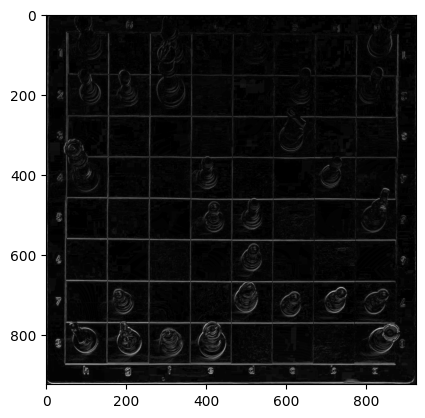

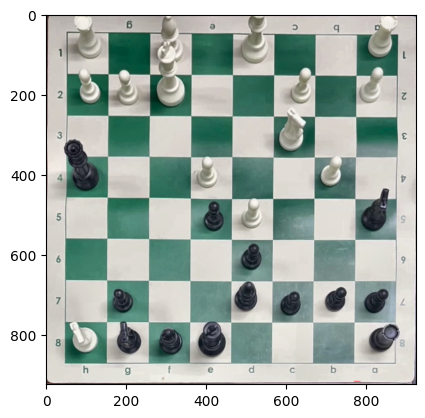

(48, 11440)

In [16]:
from frame_detector import hand_mask_skin, draw_hand_mask
import matplotlib.pyplot as plt
compute_pixel_differences(extracted_frames[1], extracted_frames[2], threshold=25)